# Generative Modeling:
### In the today's and tomorrow's tutorials, we will present several of the speciﬁc kinds of generative models.
All these models represent probability distributions over multiple variables in someway. Some allow the probability distribution function to be evaluated explicitly.Others do not allow the evaluation of the probability distribution function butsupport operations that implicitly require knowledge of it, such as drawing samplesfrom the distribution. Some of these models are structured probabilistic models described in terms of graphs and factors, using the language of graphical model. Others cannot be easily described in terms of factors butrepresent probability distributions nonetheless.

# First Type of Generative Models: Autoencoders

Anautoencoderis a neural network that is trained to attempt to copy its inputto its output. Internally, it has a hidden layerhthat describes acodeused torepresent the input. The network may be viewed as consisting of two parts: anencoder $h=f(x)$ and a decoder that produces a reconstructionr=g(h). If an autoencoder succeeds in simply learning to $g(f(x)) =x $everywhere, then it is not especially useful. Instead,autoencoders are designed to be unable to learn to copy perfectly. Usually they are restricted in ways that allow them to copy only approximately, and to copy only input that resembles the training data. Because the model is forced to prioritize which aspects of the input should be copied, it often learns useful properties of the data.


Modern autoencoders have generalized the idea of an encoder and a de-coder beyond deterministic functions to stochastic mappings $p_{encoder}(h | x)$ and $p_{decoder}(x | h)$

The idea of autoencoders has been part of the historical landscape of neuralnetworks for decades. Traditionally, autoencoders were used for dimensionality reduction orfeature learning. Recently, theoretical connections between autoencoders andlatent variable models have brought autoencoders to the forefront of generative modeling, as we will see in chapter 20. Autoencoders may be thought of as beinga special case of feedforward networks and may be trained with all the same techniques, typically minibatch gradient descent following gradients computed by back-propagation.


Source: deeplearningbook.org



In the first part, we will go over an introduction to autoencoders with three examples: the basics, image denoising, and anomaly detection. Then, we will use an advanced architecture called the variational Autoencoder (VAE). 


In [46]:
#Import TensorFlow and other libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [47]:
#Load the dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Define an autoencoder with two Dense layers: an encoder, which compresses the images into a 64 dimensional latent vector, and a decoder, that reconstructs the original image from the latent space.

To define your model, use the Keras Model Subclassing API.

In [48]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [49]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


Train the model using x_train as both the input and the target. The encoder will learn to compress the dataset from 784 dimensions to the latent space, and the decoder will learn to reconstruct the original images. 

In [50]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 2s 814us/step - loss: 0.0237 - val_loss: 0.0131
Epoch 2/10
1875/1875 [==============================] - 2s 842us/step - loss: 0.0115 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 2s 851us/step - loss: 0.0100 - val_loss: 0.0096
Epoch 4/10
1875/1875 [==============================] - 2s 933us/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 2s 931us/step - loss: 0.0091 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 1s 781us/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 2s 912us/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 2s 895us/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 2s 979us/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/

In [51]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

Now that the model is trained, let's test it by encoding and decoding images from the test set.

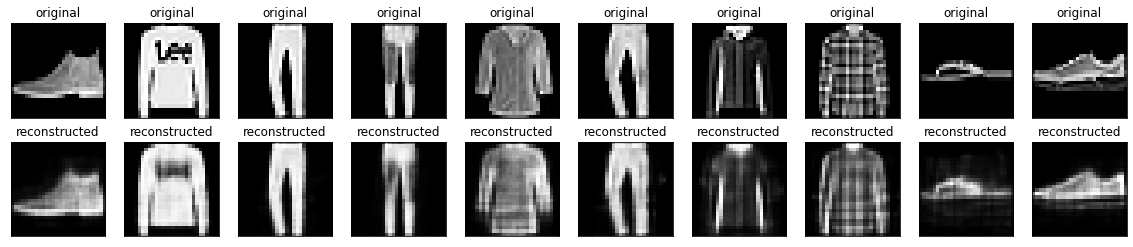

In [52]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising
An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [53]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [54]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [55]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

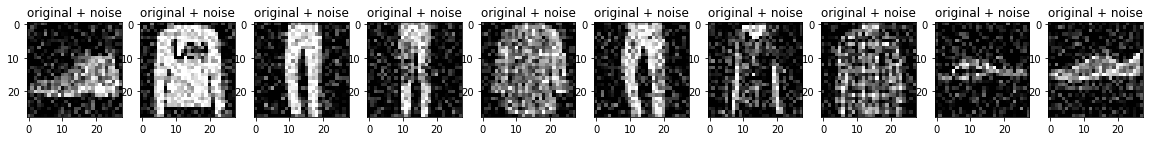

In [56]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using Conv2D layers in the encoder, and Conv2DTranspose layers in the decoder.

In [57]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [58]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [59]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0172 - val_loss: 0.0098
Epoch 2/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 3/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 4/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 5/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 6/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 7/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 8/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 9/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 10/10
1875/1875 [==============================] - 29s 15m

In [60]:
autoencoder.encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [61]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

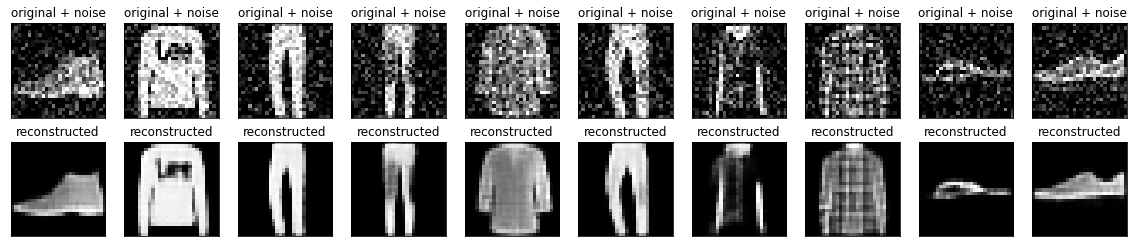

In [62]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection
### Overview

In this example, you will train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

Load ECG data

The dataset you will use is based on one from timeseriesclassification.com.


In [63]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [64]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [65]:
#Normalize the data to [0,1].

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1. Separate the normal rhythms from the abnormal rhythms.

In [66]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

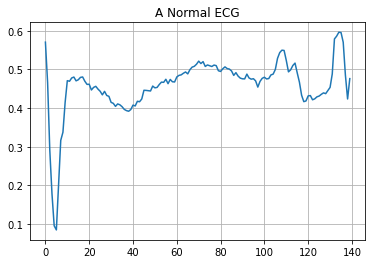

In [67]:
#Plot a normal ECG.
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

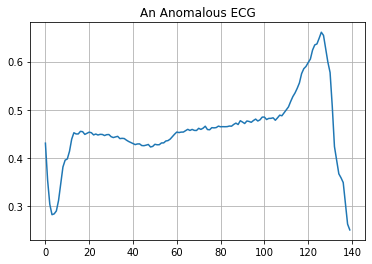

In [68]:
#Plot an anomalous ECG.
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [69]:
#Build the model
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu" ),
      layers.Dense(140, activation="sigmoid",kernel_regularizer='l2')]) #without regularization?

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [70]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.



In [71]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=1000, 
          batch_size=1024,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/1000
3/3 [==============================] - 0s 42ms/step - loss: 0.5684 - val_loss: 0.5454
Epoch 2/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.5434 - val_loss: 0.5212
Epoch 3/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.5194 - val_loss: 0.4979
Epoch 4/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.4961 - val_loss: 0.4755
Epoch 5/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.4738 - val_loss: 0.4539
Epoch 6/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.4523 - val_loss: 0.4331
Epoch 7/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.4316 - val_loss: 0.4133
Epoch 8/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.4118 - val_loss: 0.3943
Epoch 9/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.3929 - val_loss: 0.3761
Epoch 10/1000
3/3 [==============================] - ETA: 0s - loss: 0.378 - 0s 8ms/step - loss: 0.3748 - val_loss:

Epoch 83/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0231 - val_loss: 0.0355
Epoch 84/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0229 - val_loss: 0.0352
Epoch 85/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0226 - val_loss: 0.0349
Epoch 86/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0224 - val_loss: 0.0348
Epoch 87/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0222 - val_loss: 0.0345
Epoch 88/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0221 - val_loss: 0.0343
Epoch 89/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0219 - val_loss: 0.0340
Epoch 90/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0218 - val_loss: 0.0342
Epoch 91/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0217 - val_loss: 0.0335
Epoch 92/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0215 - val_loss: 0.0335
Epo

3/3 [==============================] - 0s 10ms/step - loss: 0.0190 - val_loss: 0.0288
Epoch 165/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0191 - val_loss: 0.0289
Epoch 166/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0190 - val_loss: 0.0290
Epoch 167/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0190 - val_loss: 0.0288
Epoch 168/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0190 - val_loss: 0.0288
Epoch 169/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0190 - val_loss: 0.0288
Epoch 170/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0190 - val_loss: 0.0287
Epoch 171/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0190 - val_loss: 0.0288
Epoch 172/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0190 - val_loss: 0.0288
Epoch 173/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0190 - val_loss: 0.0287
Epoch 17

3/3 [==============================] - 0s 8ms/step - loss: 0.0183 - val_loss: 0.0281
Epoch 246/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0183 - val_loss: 0.0283
Epoch 247/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0183 - val_loss: 0.0280
Epoch 248/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0183 - val_loss: 0.0282
Epoch 249/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0182 - val_loss: 0.0279
Epoch 250/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0182 - val_loss: 0.0281
Epoch 251/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0182 - val_loss: 0.0281
Epoch 252/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0182 - val_loss: 0.0280
Epoch 253/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0182 - val_loss: 0.0280
Epoch 254/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0181 - val_loss: 0.0280
Epoch 2

3/3 [==============================] - 0s 10ms/step - loss: 0.0177 - val_loss: 0.0281
Epoch 327/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0177 - val_loss: 0.0279
Epoch 328/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0177 - val_loss: 0.0280
Epoch 329/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0177 - val_loss: 0.0281
Epoch 330/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0177 - val_loss: 0.0279
Epoch 331/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0177 - val_loss: 0.0281
Epoch 332/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0177 - val_loss: 0.0280
Epoch 333/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0177 - val_loss: 0.0279
Epoch 334/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0177 - val_loss: 0.0281
Epoch 335/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0177 - val_loss: 0.0279
Epoch 

3/3 [==============================] - 0s 10ms/step - loss: 0.0174 - val_loss: 0.0283
Epoch 408/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0175 - val_loss: 0.0281
Epoch 409/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0174 - val_loss: 0.0281
Epoch 410/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0174 - val_loss: 0.0283
Epoch 411/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0174 - val_loss: 0.0282
Epoch 412/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0174 - val_loss: 0.0281
Epoch 413/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0174 - val_loss: 0.0283
Epoch 414/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0173 - val_loss: 0.0282
Epoch 415/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0173 - val_loss: 0.0281
Epoch 416/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0173 - val_loss: 0.0282
Epoch 

3/3 [==============================] - 0s 14ms/step - loss: 0.0171 - val_loss: 0.0283
Epoch 489/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0171 - val_loss: 0.0283
Epoch 490/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0171 - val_loss: 0.0285
Epoch 491/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0172 - val_loss: 0.0283
Epoch 492/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0172 - val_loss: 0.0283
Epoch 493/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0172 - val_loss: 0.0284
Epoch 494/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0171 - val_loss: 0.0282
Epoch 495/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0171 - val_loss: 0.0285
Epoch 496/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0172 - val_loss: 0.0282
Epoch 497/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0172 - val_loss: 0.0284
Epoch

3/3 [==============================] - 0s 12ms/step - loss: 0.0170 - val_loss: 0.0285
Epoch 570/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0170 - val_loss: 0.0286
Epoch 571/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0170 - val_loss: 0.0285
Epoch 572/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0170 - val_loss: 0.0285
Epoch 573/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0170 - val_loss: 0.0286
Epoch 574/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0170 - val_loss: 0.0286
Epoch 575/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0170 - val_loss: 0.0286
Epoch 576/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0170 - val_loss: 0.0284
Epoch 577/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0170 - val_loss: 0.0287
Epoch 578/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0170 - val_loss: 0.0285
Epoch

3/3 [==============================] - 0s 23ms/step - loss: 0.0169 - val_loss: 0.0289
Epoch 651/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0169 - val_loss: 0.0286
Epoch 652/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0169 - val_loss: 0.0287
Epoch 653/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0169 - val_loss: 0.0288
Epoch 654/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0169 - val_loss: 0.0287
Epoch 655/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0169 - val_loss: 0.0287
Epoch 656/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0169 - val_loss: 0.0287
Epoch 657/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0169 - val_loss: 0.0288
Epoch 658/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0169 - val_loss: 0.0287
Epoch 659/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0169 - val_loss: 0.0288
Epoch

3/3 [==============================] - 0s 14ms/step - loss: 0.0168 - val_loss: 0.0288
Epoch 732/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0168 - val_loss: 0.0290
Epoch 733/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0168 - val_loss: 0.0289
Epoch 734/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0168 - val_loss: 0.0289
Epoch 735/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0168 - val_loss: 0.0289
Epoch 736/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0168 - val_loss: 0.0289
Epoch 737/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0168 - val_loss: 0.0289
Epoch 738/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0168 - val_loss: 0.0289
Epoch 739/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0168 - val_loss: 0.0290
Epoch 740/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0168 - val_loss: 0.0289
Epoch 

3/3 [==============================] - 0s 12ms/step - loss: 0.0167 - val_loss: 0.0289
Epoch 813/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0168 - val_loss: 0.0290
Epoch 814/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0168 - val_loss: 0.0293
Epoch 815/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0168 - val_loss: 0.0289
Epoch 816/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0168 - val_loss: 0.0291
Epoch 817/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0168 - val_loss: 0.0290
Epoch 818/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0168 - val_loss: 0.0290
Epoch 819/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0168 - val_loss: 0.0292
Epoch 820/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0168 - val_loss: 0.0290
Epoch 821/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0168 - val_loss: 0.0291
Epoch 822/10

3/3 [==============================] - 0s 12ms/step - loss: 0.0167 - val_loss: 0.0293
Epoch 894/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0167 - val_loss: 0.0291
Epoch 895/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0167 - val_loss: 0.0293
Epoch 896/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0167 - val_loss: 0.0291
Epoch 897/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0167 - val_loss: 0.0292
Epoch 898/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0167 - val_loss: 0.0291
Epoch 899/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0167 - val_loss: 0.0292
Epoch 900/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0167 - val_loss: 0.0292
Epoch 901/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0167 - val_loss: 0.0291
Epoch 902/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0167 - val_loss: 0.0293
Epoch

3/3 [==============================] - 0s 8ms/step - loss: 0.0167 - val_loss: 0.0293
Epoch 975/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0166 - val_loss: 0.0293
Epoch 976/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0167 - val_loss: 0.0292
Epoch 977/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0167 - val_loss: 0.0293
Epoch 978/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0167 - val_loss: 0.0293
Epoch 979/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0167 - val_loss: 0.0292
Epoch 980/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0167 - val_loss: 0.0293
Epoch 981/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0167 - val_loss: 0.0292
Epoch 982/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0167 - val_loss: 0.0293
Epoch 983/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0167 - val_loss: 0.0292
Epoch 984/

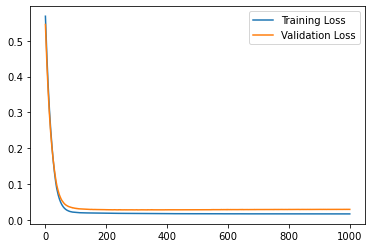

In [72]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

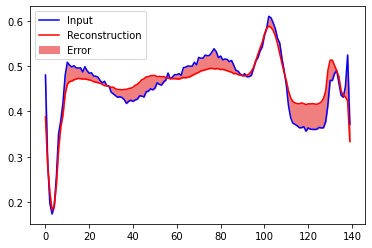

In [73]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

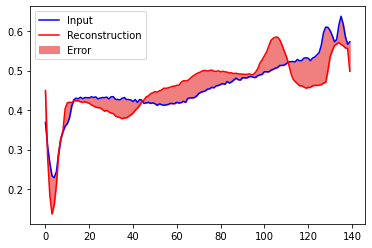

In [74]:
#Create a similar plot, this time for an anomalous test example.

encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Plot the reconstruction error on normal ECGs from the training set

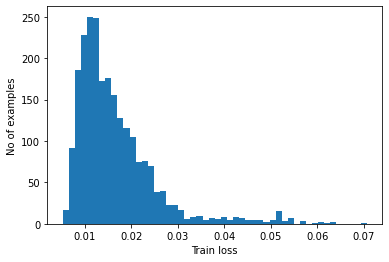

In [75]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [76]:
#Choose a threshold value that is one standard deviations above the mean.
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.025294434


If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the precision and recall of your classifier.

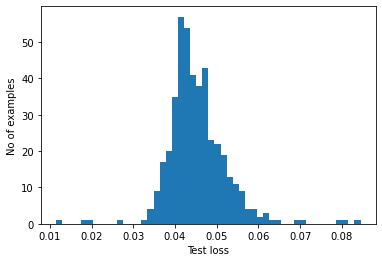

In [77]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [78]:
# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [79]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.934
Precision = 0.994
Recall = 0.8875


To learn more about anomaly detection with autoencoders, check out this excellent interactive example built with TensorFlow.js by Victor Dibia. (https://anomagram.fastforwardlabs.com/#/)

# Variational Autoencoder

In this tutroial we will develop a convolutional variational autoencoder (VAE).

A variational autoencoder,also known as VAE, is the artificial neural network architecture introduced by Diederik P Kingma and Max Welling, belonging to the families of probabilistic graphical models and variational Bayesian methods.

https://arxiv.org/pdf/1312.6114.pdf


    ''' How can we perform efficient inference and learning in directed probabilistic
    models, in the presence of continuous latent variables with intractable posterior
    distributions, and large datasets? We introduce a stochastic variational inference
            and learning algorithm that scales to large datasets and, under some mild differentiability conditions, even works in the intractable case. '''

We demonstrate such apporach on the MNIST dataset by taking high dimensional input data and compresses it into a smaller representation

Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.


<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" alt="Diagram of one-hot encodings" width="800" />

In [80]:
%pip install tensorflow-probability

Note: you may need to restart the kernel to use updated packages.


In [81]:
%pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [82]:
%pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\asa279\appdata\local\temp\pip-req-build-ho5boh2f
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://github.com/tensorflow/docs 'C:\Users\asa279\AppData\Local\Temp\pip-req-build-ho5boh2f'


In [83]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [84]:
#Load the MNIST dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [85]:
#Preprocess the data
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [86]:
#Specify sets and batch
train_size = 60000
batch_size = 32
test_size = 10000

In [87]:
#Use tf.data to batch and shuffle the data
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Now Let's define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
Output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [88]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

In [89]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* Note: Since you use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here, plot the probabilities of Bernoulli distributions

In [90]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [91]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [92]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -156.9999237060547, time elapse for current epoch: 29.402565002441406


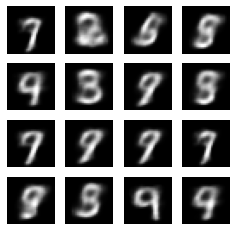

In [93]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

(-0.5, 287.5, 287.5, -0.5)

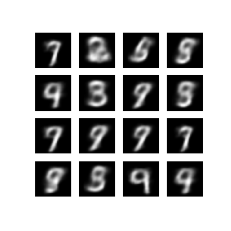

In [94]:
#Display a generated image from the last training epoch
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [95]:
# Display an animated GIF of all the saved images
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


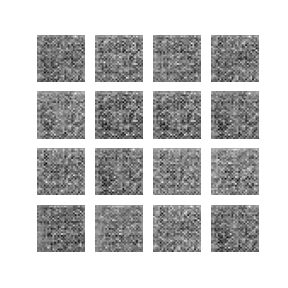

In [96]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [97]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

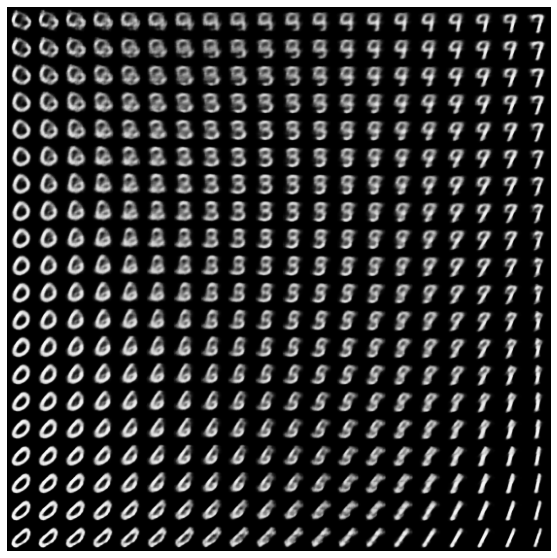

In [98]:
plot_latent_images(model, 20)

## Tips for implementing VAE in Tensorflow

### The output layer of encoder
    1. tfpl.IndependentNormal
    2. tfkl.Dense that outputs (concatenated) mean and (raw) standard deviation of the posterior distribution of z
### The output layer of decoder
    1. tfpl.IndependentBernoulli
    2. tfpl.IndependentBernoulli.mean
    3. tfkl.Conv2DTranspose that outputs the logits
### The loss function
    1. negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
    2. tf.nn.sigmoid_cross_entropy_with_logits
    3. tfk.losses.BinaryCrossentropy
    4. tf.nn.sigmoid_cross_entropy_with_logits + tfkl.Layer.add_loss

# Advnaced: Transformer-based Encoder-Decoder Models


In [99]:
%pip install transformers==4.2.1
%pip install sentencepiece==0.1.95

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [100]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [101]:
from transformers import MarianMTModel, MarianTokenizer

tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-de")

# create ids of encoded input vectors
input_ids = tokenizer("I want to buy a car", return_tensors="pt").input_ids

# translate example
output_ids = model.generate(input_ids)[0]

# decode and print
print(tokenizer.decode(output_ids))

<pad> Ich will ein Auto kaufen


In [102]:
from transformers import MarianMTModel, MarianTokenizer
import torch

tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-de")

embeddings = model.get_input_embeddings()

# create ids of encoded input vectors
input_ids = tokenizer("I want to buy a car", return_tensors="pt").input_ids

# pass input_ids to encoder
encoder_hidden_states = model.base_model.encoder(input_ids, return_dict=True).last_hidden_state

# change the input slightly and pass to encoder
input_ids_perturbed = tokenizer("I want to buy a house", return_tensors="pt").input_ids
encoder_hidden_states_perturbed = model.base_model.encoder(input_ids_perturbed, return_dict=True).last_hidden_state

# compare shape and encoding of first vector
print(f"Length of input embeddings {embeddings(input_ids).shape[1]}. Length of encoder_hidden_states {encoder_hidden_states.shape[1]}")

# compare values of word embedding of "I" for input_ids and perturbed input_ids
print("Is encoding for `I` equal to its perturbed version?: ", torch.allclose(encoder_hidden_states[0, 0], encoder_hidden_states_perturbed[0, 0], atol=1e-3))

Length of input embeddings 7. Length of encoder_hidden_states 7
Is encoding for `I` equal to its perturbed version?:  False


In [103]:
from transformers import MarianMTModel, MarianTokenizer
import torch

tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-de")
embeddings = model.get_input_embeddings()

# get encoded input vectors
input_ids = tokenizer("I want to buy a car", return_tensors="pt").input_ids

# create ids of encoded input vectors
decoder_input_ids = tokenizer("<pad> Ich will ein", return_tensors="pt", add_special_tokens=False).input_ids

# pass decoder input_ids and encoded input vectors to decoder
decoder_output_vectors = model.base_model.decoder(decoder_input_ids).last_hidden_state

# derive embeddings by multiplying decoder outputs with embedding weights
lm_logits = torch.nn.functional.linear(decoder_output_vectors, embeddings.weight, bias=model.final_logits_bias)

# change the decoder input slightly
decoder_input_ids_perturbed = tokenizer("<pad> Ich will das", return_tensors="pt", add_special_tokens=False).input_ids
decoder_output_vectors_perturbed = model.base_model.decoder(decoder_input_ids_perturbed).last_hidden_state
lm_logits_perturbed = torch.nn.functional.linear(decoder_output_vectors_perturbed, embeddings.weight, bias=model.final_logits_bias)

# compare shape and encoding of first vector
print(f"Shape of decoder input vectors {embeddings(decoder_input_ids).shape}. Shape of decoder logits {lm_logits.shape}")

# compare values of word embedding of "I" for input_ids and perturbed input_ids
print("Is encoding for `Ich` equal to its perturbed version?: ", torch.allclose(lm_logits[0, 0], lm_logits_perturbed[0, 0], atol=1e-3))

Shape of decoder input vectors torch.Size([1, 5, 512]). Shape of decoder logits torch.Size([1, 5, 58101])
Is encoding for `Ich` equal to its perturbed version?:  True


In [104]:
from transformers import MarianMTModel, MarianTokenizer
import torch

tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-de")

# create ids of encoded input vectors
input_ids = tokenizer("I want to buy a car", return_tensors="pt").input_ids

# create BOS token
decoder_input_ids = tokenizer("<pad>", add_special_tokens=False, return_tensors="pt").input_ids

assert decoder_input_ids[0, 0].item() == model.config.decoder_start_token_id, "`decoder_input_ids` should correspond to `model.config.decoder_start_token_id`"

# STEP 1

# pass input_ids to encoder and to decoder and pass BOS token to decoder to retrieve first logit
outputs = model(input_ids, decoder_input_ids=decoder_input_ids, return_dict=True)

# get encoded sequence
encoded_sequence = (outputs.encoder_last_hidden_state,)
# get logits
lm_logits = outputs.logits

# sample last token with highest prob
next_decoder_input_ids = torch.argmax(lm_logits[:, -1:], axis=-1)

# concat
decoder_input_ids = torch.cat([decoder_input_ids, next_decoder_input_ids], axis=-1)

# STEP 2

# reuse encoded_inputs and pass BOS + "Ich" to decoder to second logit
lm_logits = model(None, encoder_outputs=encoded_sequence, decoder_input_ids=decoder_input_ids, return_dict=True).logits

# sample last token with highest prob again
next_decoder_input_ids = torch.argmax(lm_logits[:, -1:], axis=-1)

# concat again
decoder_input_ids = torch.cat([decoder_input_ids, next_decoder_input_ids], axis=-1)

# STEP 3
lm_logits = model(None, encoder_outputs=encoded_sequence, decoder_input_ids=decoder_input_ids, return_dict=True).logits
next_decoder_input_ids = torch.argmax(lm_logits[:, -1:], axis=-1)
decoder_input_ids = torch.cat([decoder_input_ids, next_decoder_input_ids], axis=-1)

# let's see what we have generated so far!
print(f"Generated so far: {tokenizer.decode(decoder_input_ids[0], skip_special_tokens=True)}")

# This can be written in a loop as well.

Generated so far: Ich will ein


For more on this example: https://huggingface.co/blog/encoder-decoder

# Advanced:  Adversarial training!

This is the concept of mapping the encoder’s output distribution $q(z|x)$ to an arbitrary prior distribution $p(z)$ using adversarial training (rather than variational inference).

Unfortunately, variational autoencoders often leave regions in the space of the prior distribution that do not map to realistic samples from the data. Adversarial autoencoders aim to improve this by encouraging the output of the encoder to fill the space of the prior distribution entirely, thereby allowing the decoder to generate realistic looking samples from any data point sampled from the prior. Instead of using variational inference, adversarial autoencoders do this by introducing two new components, namely the discriminator and the generator.

For every minibatch, there are three important events:

1. A minibatch of input vectors is encoded and decoded by the encoder and decoder, respectively, after which both the encoder and decoder are updated based on the standard reconstruction loss.
2. A minibatch of input vectors is transformed by the encoder, after which the minibatch is concatenated with code vectors sampled from the prior distribution. The discriminator is then updated using a binary cross-entropy loss based on its ability to separate those samples generated by the encoder from those sampled from the prior distribution.
3. A minibatch of input vectors is transformed by the encoder, the source of these data points is predicted by the discriminator, and the generator (which is also the encoder) is updated using a binary cross-entropy loss based on its ability to fool the discriminator into thinking the data points came from the prior distribution.



 First, the MNIST Dataset is imported

In [105]:
import numpy as np
import keras as ke
import pandas as pd
import matplotlib.pyplot as plt

x_train = train_images

In [106]:
def build_model_enc():
    model = ke.models.Sequential()
    model.add(ke.layers.Conv2D(32, (5,5), padding="same", activation="relu", input_shape=(28, 28, 1)))
    model.add(ke.layers.Conv2D(64, (5,5), strides=(2,2), activation="relu", padding="same"))
    model.add(ke.layers.Conv2D(128, (5,5), strides=(2,2), activation="relu", padding="same"))
    model.add(ke.layers.Flatten())
    model.add(ke.layers.Dense(2, activation="linear"))

    return model

def build_model_dec():
    model = ke.models.Sequential()
    model.add(ke.layers.Dense(6272, input_shape=(2,)))
    model.add(ke.layers.Reshape((7, 7, 128)))
    model.add(ke.layers.Conv2D(64, (5,5), activation="relu", padding="same"))
    model.add(ke.layers.UpSampling2D())
    model.add(ke.layers.Conv2D(32, (5,5), activation="relu", padding="same"))
    model.add(ke.layers.UpSampling2D())
    model.add(ke.layers.Conv2D(1, (5,5), activation="sigmoid", padding="same"))

    return model

def build_model_disc():
    model = ke.models.Sequential()
    model.add(ke.layers.Dense(32, activation="relu", input_shape=(2,)))
    model.add(ke.layers.Dense(32, activation="relu"))
    model.add(ke.layers.Dense(1, activation="sigmoid"))
    return model

In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_model_aae():
    model_enc = build_model_enc()
    model_dec = build_model_dec()
    model_disc = build_model_disc()
    
    model_ae = ke.models.Sequential()
    model_ae.add(model_enc)
    model_ae.add(model_dec)
    
    model_enc_disc = ke.models.Sequential()
    model_enc_disc.add(model_enc)
    model_enc_disc.add(model_disc)
    
    return model_enc, model_dec, model_disc, model_ae, model_enc_disc

model_enc, model_dec, model_disc, model_ae, model_enc_disc = build_model_aae()

model_enc.summary()
model_dec.summary()
model_disc.summary()
model_ae.summary()
model_enc_disc.summary()

model_disc.compile(optimizer='adam', loss="binary_crossentropy")
model_enc_disc.compile(optimizer='adam', loss="binary_crossentropy")
model_ae.compile(optimizer='adam', loss="binary_crossentropy")

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
flatten_15 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_75 (Dense)             (None, 2)                 12546     
Total params: 269,570
Trainable params: 269,570
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_76"
_________________________________________________________________
Layer (type)            

In [108]:
def imagegrid(dec, epochnumber):        
        fig = plt.figure(figsize=[20, 20])
        
        for i in range(-5, 5):
            for j in range(-5,5):
                topred = np.array((i*0.5,j*0.5))
                topred = topred.reshape((1, 2))
                img = dec.predict(topred)
                img = img.reshape((28, 28))
                ax = fig.add_subplot(10, 10, (i+5)*10+j+5+1)
                ax.set_axis_off()
                ax.imshow(img, cmap="gray")
        
        fig.savefig(str(epochnumber)+".png")
        plt.show()
        plt.close(fig)
        
def settrainable(model, toset):
    for layer in model.layers:
        layer.trainable = toset
    model.trainable = toset

Reconstruction Loss: 0.24404408037662506
Adverserial Loss: 0.09314507991075516


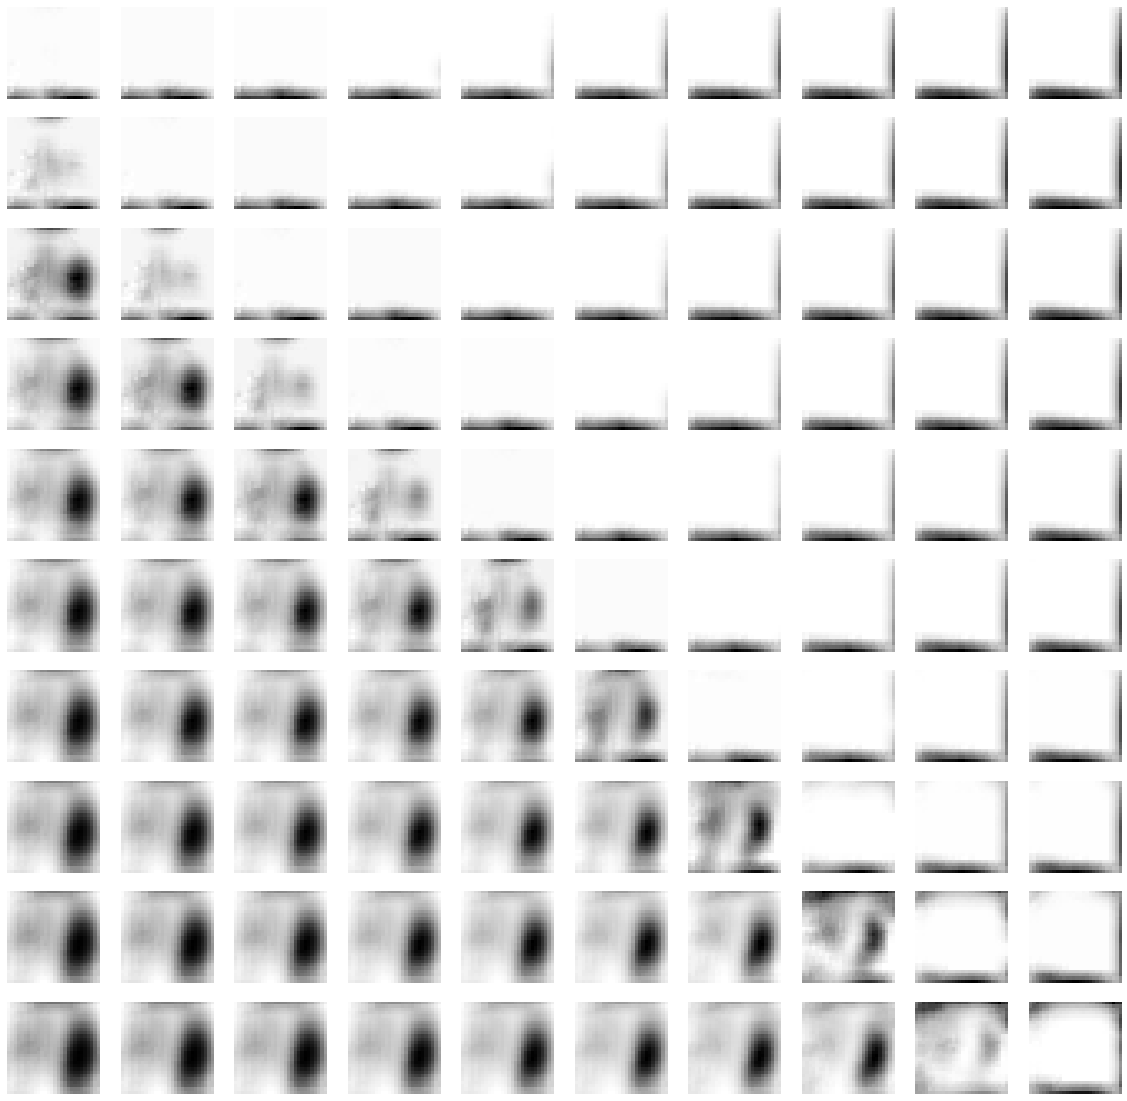

Reconstruction Loss: 0.24380391836166382
Adverserial Loss: 7.102363402261558e-12


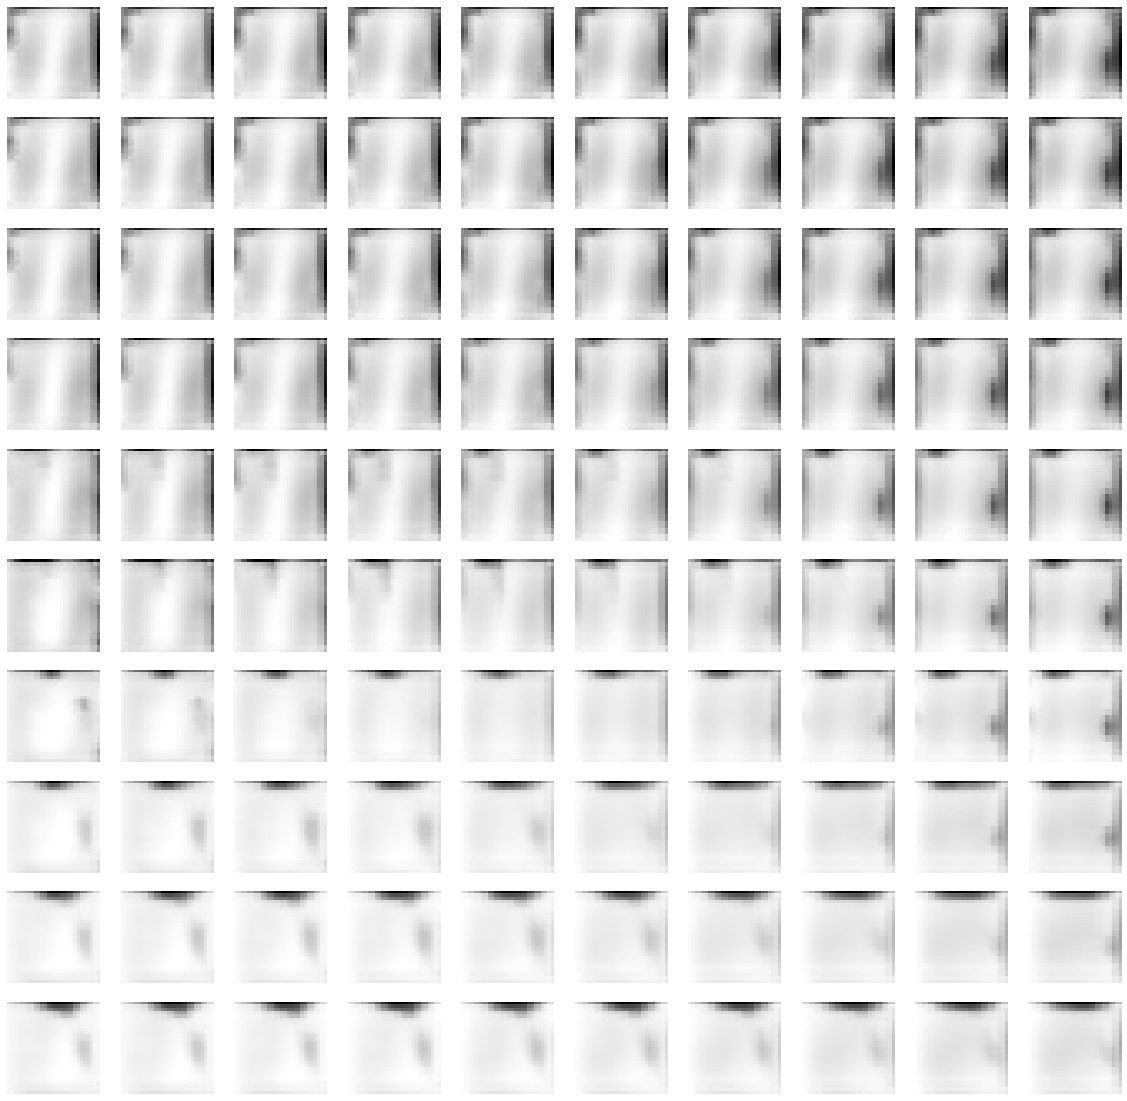

Reconstruction Loss: 0.2411167025566101
Adverserial Loss: 3.5245133579480043e-16


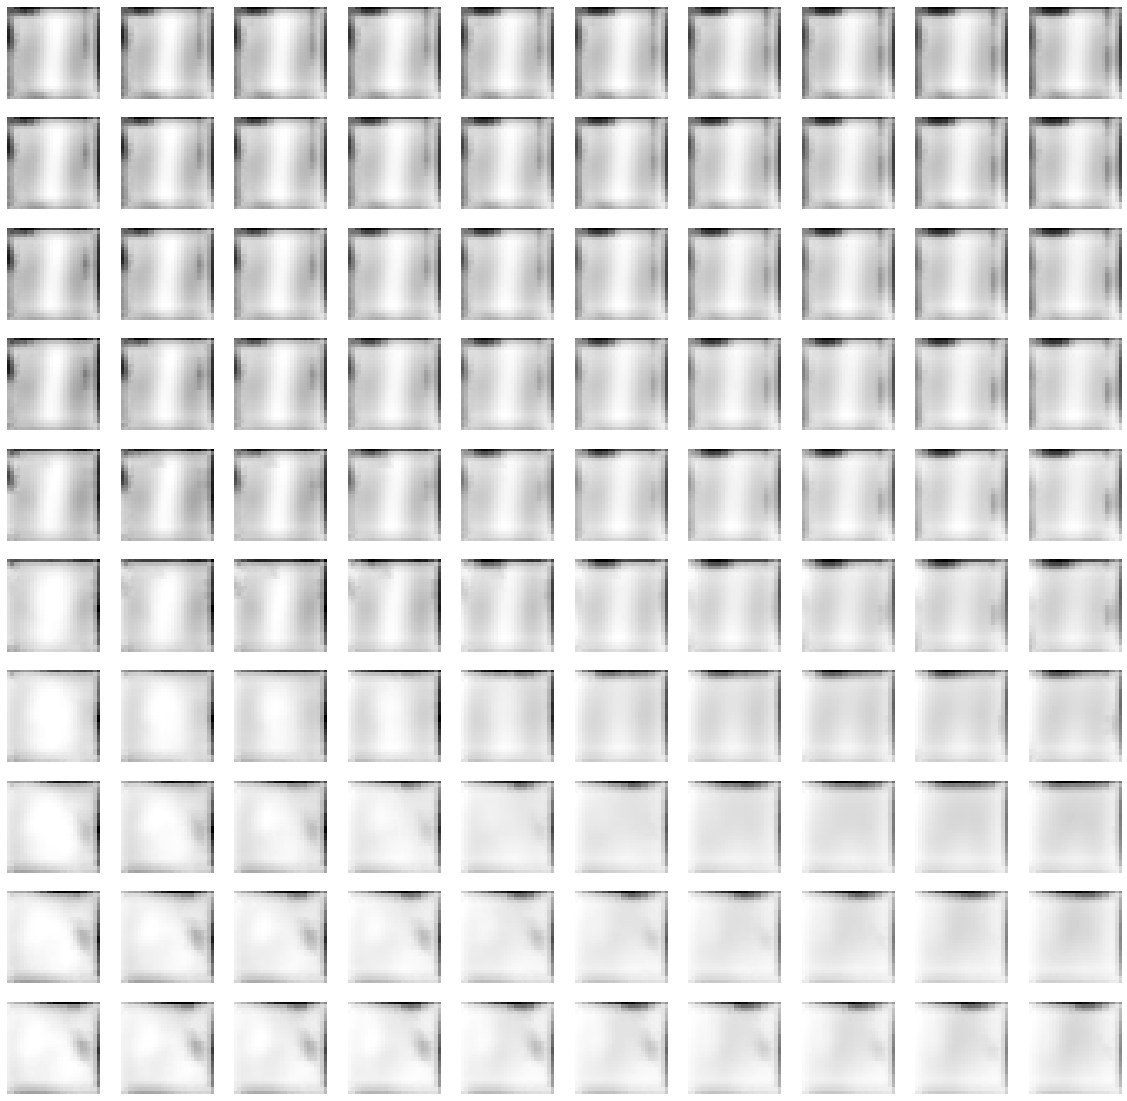

Reconstruction Loss: 0.23913592100143433
Adverserial Loss: 2.6238546168803606e-22


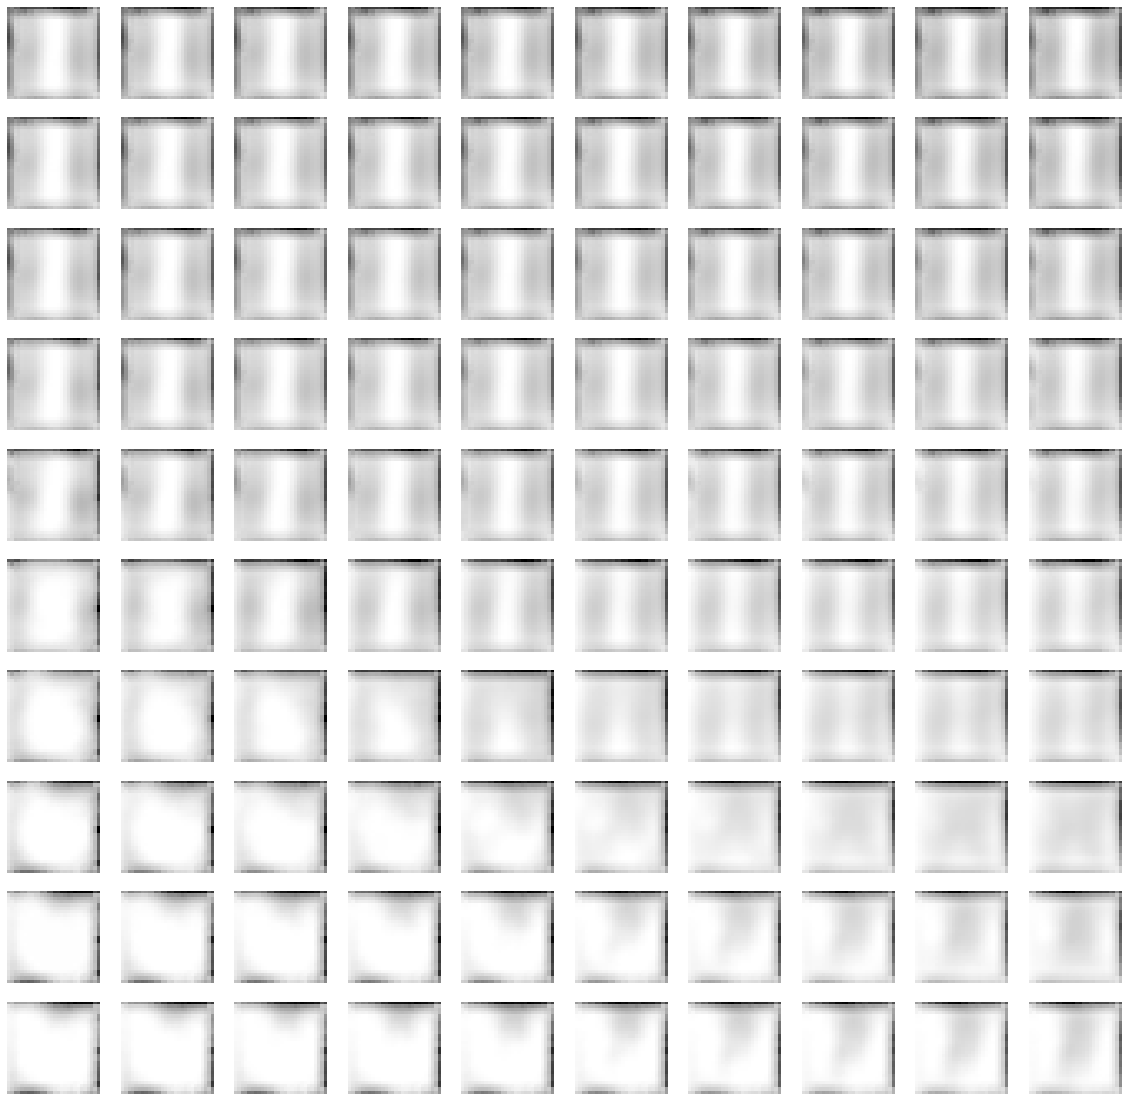

Reconstruction Loss: 0.23237258195877075
Adverserial Loss: 1.8103605535513007e-15


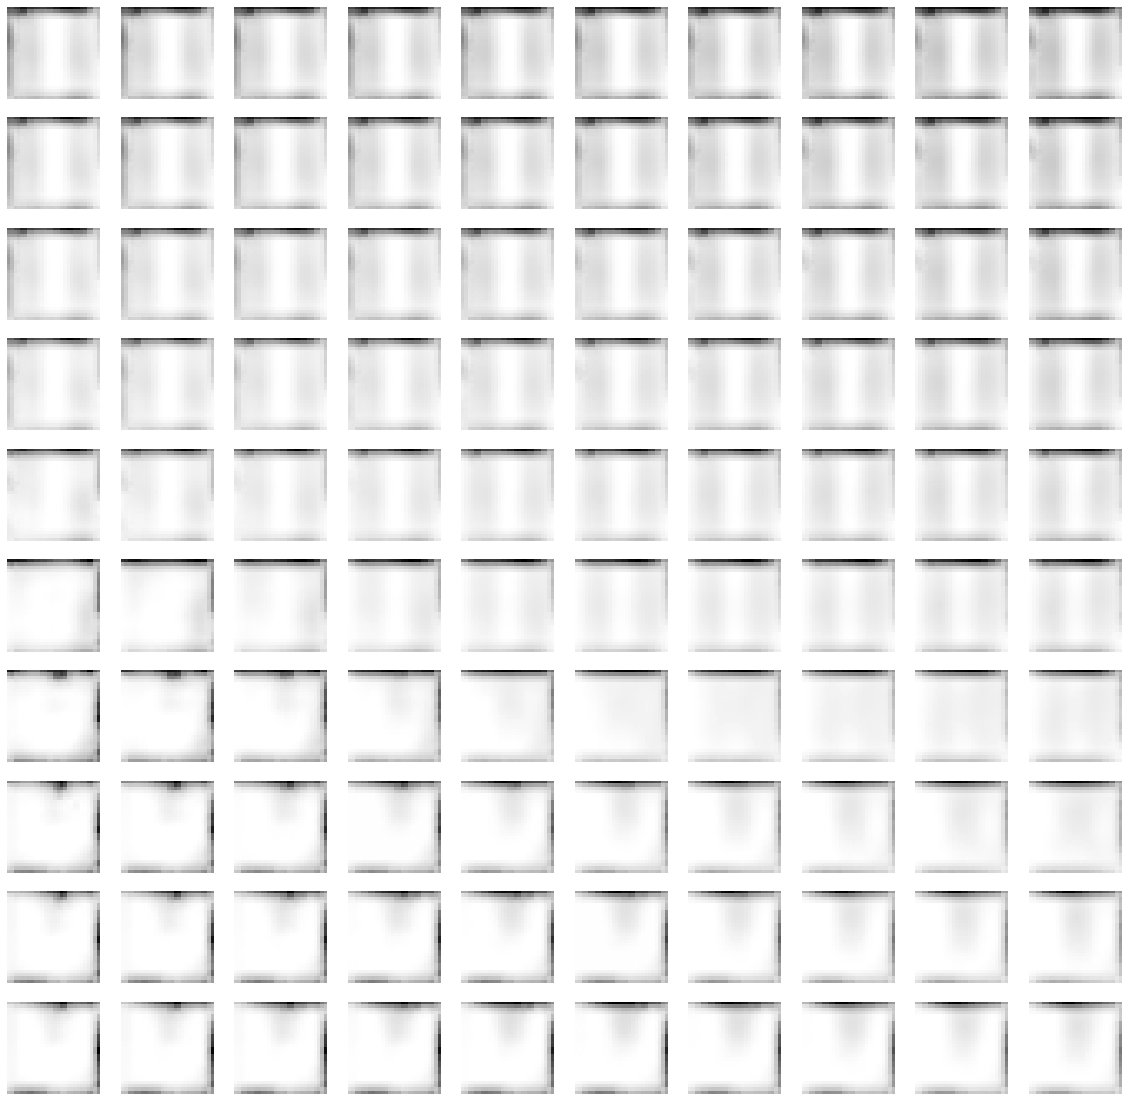

In [ ]:
batchsize=50
#Set Number of Epochs to 10-20 or higher.
for epochnumber in range(10):
    np.random.shuffle(x_train)
    
    for i in range(int(len(x_train) / batchsize)):
        settrainable(model_ae, True)
        settrainable(model_enc, True)
        settrainable(model_dec, True)
        
        batch = x_train[i*batchsize:i*batchsize+batchsize]
        model_ae.train_on_batch(batch, batch)
        
        settrainable(model_disc, True)
        batchpred = model_enc.predict(batch)
        fakepred = np.random.standard_normal((batchsize,2))
        discbatch_x = np.concatenate([batchpred, fakepred])
        discbatch_y = np.concatenate([np.zeros(batchsize), np.ones(batchsize)])
        model_disc.train_on_batch(discbatch_x, discbatch_y)
        
        settrainable(model_enc_disc, True)
        settrainable(model_enc, True)
        settrainable(model_disc, False)
        model_enc_disc.train_on_batch(batch, np.ones(batchsize))
    
    print ("Reconstruction Loss:", model_ae.evaluate(x_train, x_train, verbose=0))
    print ("Adverserial Loss:", model_enc_disc.evaluate(x_train, np.ones(len(x_train)), verbose=0))
    
    
    imagegrid(model_dec, epochnumber) 

Additional tutorial on building custom VAE layers:
https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example


References:
    - François Chollet
    - https://www.tensorflow.org/
    - towardsdatascience.com
    - huggingface.co
    - https://hjweide.github.io
    - https://www.kaggle.com/ankasor/adversarial-autoencoding-with-keras